# Training CNN model

## Set up notebook

### Import dependencies

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [ ]:
print(tf.__version__)

2.15.0


### Limit GPU usage

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparing data


### Import data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = Path("/content/drive/MyDrive/Dataset/Newest_data_train")
test_dir = Path("/content/drive/MyDrive/Dataset/Newest_data_test")
print("train data:", train_dir.exists())
print("test data:", test_dir.exists())

train: True
test: True


In [ ]:
train_img_count = len(list(train_dir.glob("*/*.jpg")))
test_img_count = len(list(test_dir.glob("*/*.jpg")))
print(train_img_count + test_img_count, "images found")

2534 jpg images found


### Load data into training set and validation set

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
COLOR = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    shuffle=True,
    seed=716,
    image_size=IMAGE_SIZE,
    color_mode=COLOR,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    shuffle=True,
    seed=295,
    image_size=IMAGE_SIZE,
    color_mode=COLOR,
)
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
NUM_BATCH = int(train_ds.cardinality().numpy())

Found 2475 files belonging to 99 classes.
Found 653 files belonging to 99 classes.


In [ ]:
CLASS_NAMES

### Visualize the data


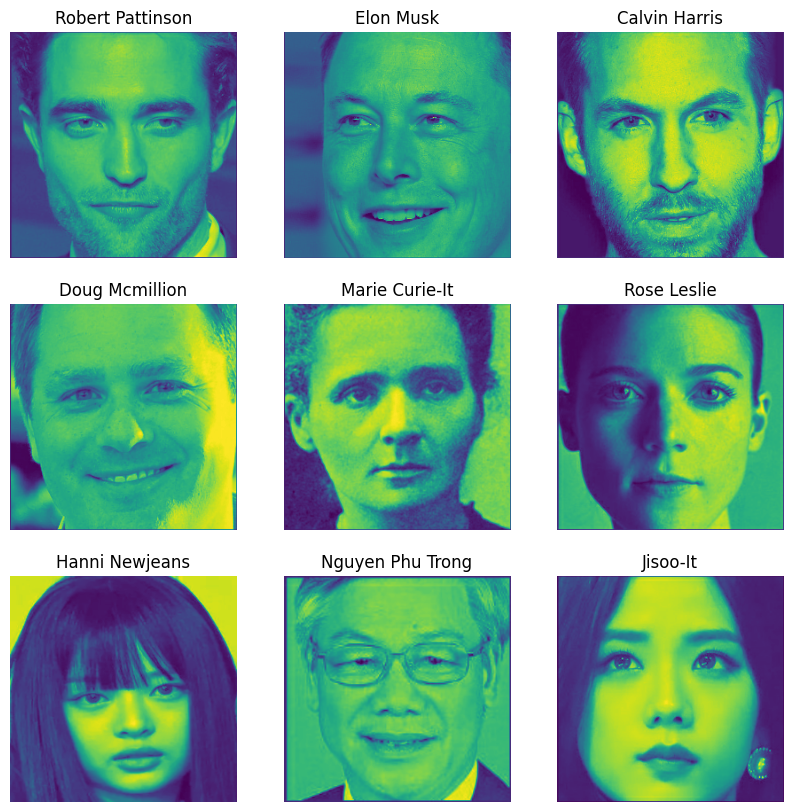

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

### Data augmentation


In [ ]:
from keras import Sequential
from keras.layers import RandomBrightness, RandomFlip, RandomZoom, RandomRotation

data_augmentation = Sequential(
    [
        RandomBrightness((-0.3, 0.3)),
        RandomFlip("horizontal"),
        RandomZoom((-0.3, 0.3)),
        RandomRotation(0.12),
    ],
    name="augmentation",
)

### Show augmentation

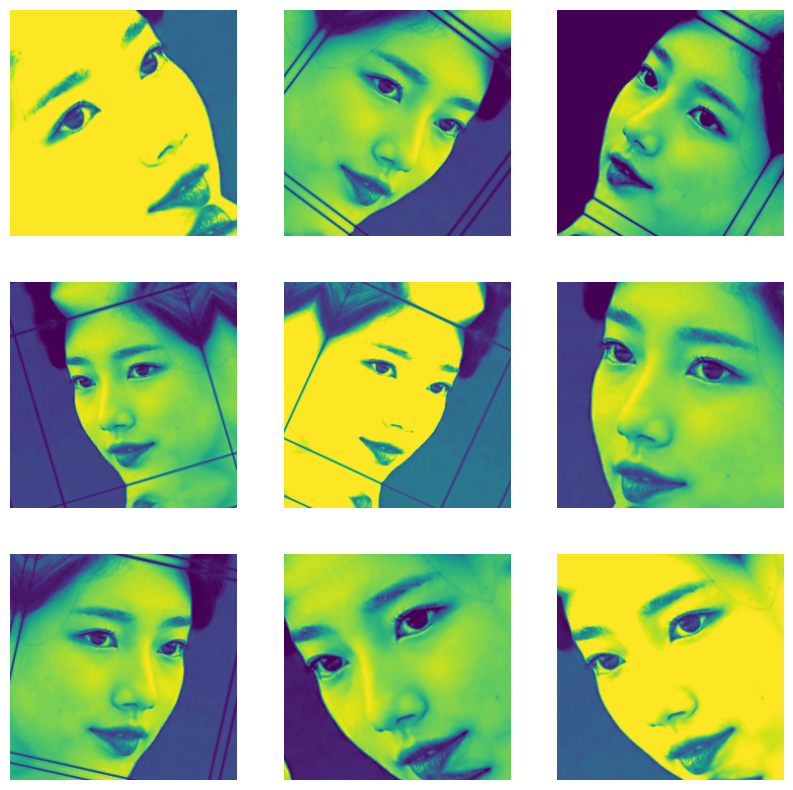

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Configure dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training the model

### CNN model

In [ ]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense
from keras.layers import Rescaling, Flatten, Dropout, BatchNormalization

def create_model():
    model = Sequential(name="CNN_model",
        layers = [
            # Input
            Input(shape=IMAGE_SIZE + (1,), name="input"),
            # Data augmentation
            data_augmentation,
            # Normalization
            Rescaling(1.0 / 255),
            # Convo layers
            # Block 1
            Conv2D(32, 3, activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(32, 3, activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            # Block 2
            Conv2D(64, 3, activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(64, 3, activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            # Block 3
            Conv2D(128, 3, activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(128, 3, activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Dropout(0.05),
            # Block 4
            Conv2D(256, 3, activation="relu", padding="same"),
            BatchNormalization(),
            Conv2D(256, 3, activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Dropout(0.1),
            # Flatten
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.65),
            Dense(NUM_CLASSES, activation="softmax", name="output"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',
        metrics=["accuracy"],
    )

    return model


# Create a basic model instance
model = create_model()

### Build model

In [ ]:
model_path = "/content/drive/MyDrive/Model/cnn_model_3.keras"
weights_path = "/content/drive/MyDrive/Model/cnn_model_weights_3.keras"
model.build()
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 aug_layer (Sequential)      (None, 224, 224, 1)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 1)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_18 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_19 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                       

### Train model

In [ ]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

EPOCHS = 200
FREQ = 10

def custom_lr(epoch):
    if epoch < 50:
        return 0.0002
    if epoch < 80:
        return 0.0001
    return 0.00001

lr = LearningRateScheduler(custom_lr)

mc = ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    verbose=1,
    save_weights_only=True,
    save_freq=FREQ * NUM_BATCH,
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=100,
)

history = model.fit(
    train_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[lr, mc, es],
    validation_data=val_ds,
)

Epoch 1/200
78/78 [==============================] - 26s 245ms/step - loss: 5.3526 - accuracy: 0.0259 - val_loss: 5.6444 - val_accuracy: 0.0138 - lr: 2.0000e-04
Epoch 2/200
78/78 [==============================] - 19s 242ms/step - loss: 4.7734 - accuracy: 0.0505 - val_loss: 6.1566 - val_accuracy: 0.0138 - lr: 2.0000e-04
Epoch 3/200
78/78 [==============================] - 19s 246ms/step - loss: 4.5420 - accuracy: 0.0683 - val_loss: 5.1828 - val_accuracy: 0.0138 - lr: 2.0000e-04
Epoch 4/200
78/78 [==============================] - 19s 245ms/step - loss: 4.2841 - accuracy: 0.1010 - val_loss: 5.0201 - val_accuracy: 0.0153 - lr: 2.0000e-04
Epoch 5/200
78/78 [==============================] - 19s 246ms/step - loss: 3.9606 - accuracy: 0.1269 - val_loss: 4.6254 - val_accuracy: 0.0337 - lr: 2.0000e-04
Epoch 6/200
78/78 [==============================] - 19s 248ms/step - loss: 3.8228 - accuracy: 0.1341 - val_loss: 3.8215 - val_accuracy: 0.1302 - lr: 2.0000e-04
Epoch 7/200
78/78 [===============

### Performance

In [ ]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    lr = history.history["lr"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(len(train_loss))

    fig, ax = plt.subplots(1, 2)

    # Plot loss
    ax[1].set_title("Model loss")
    ax2 = ax[1].twinx()
    ax[1].set_xlabel("Epochs")
    ax2.set_ylabel("Learning rate")
    ax[1].plot(epochs, train_loss, color="b", label="Train")
    ax[1].plot(epochs, val_loss, color="r", label="Validation")
    ax2.plot(epochs, lr, color="g", label="Learning Rate")
    fig.legend()
    # Plot accuracy
    ax[0].set_title("Model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].plot(epochs, acc, color="b", label="Train")
    ax[0].plot(epochs, val_acc, color="r", label="Validation")


    plt.show()

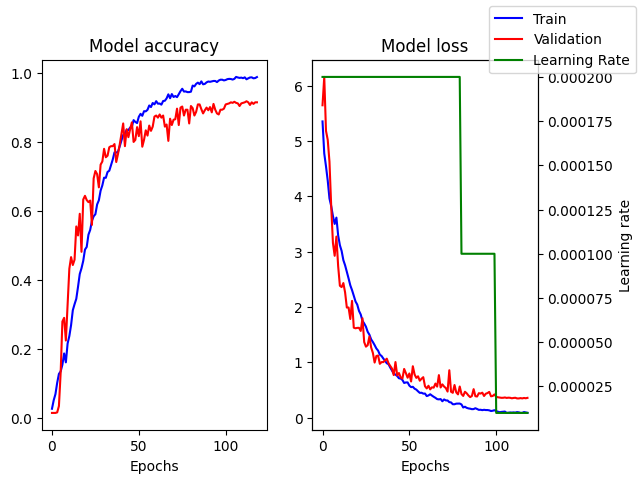

In [ ]:
plot_loss_acc(history)

### Save the model weights

In [ ]:
model.save_weights(weights_path)

## Prediction

### Load trained model

In [ ]:
trained_model = create_model()
trained_model.load_weights(weights_path)

### Show prediction

1/1 [==============================] - 0s 219ms/step


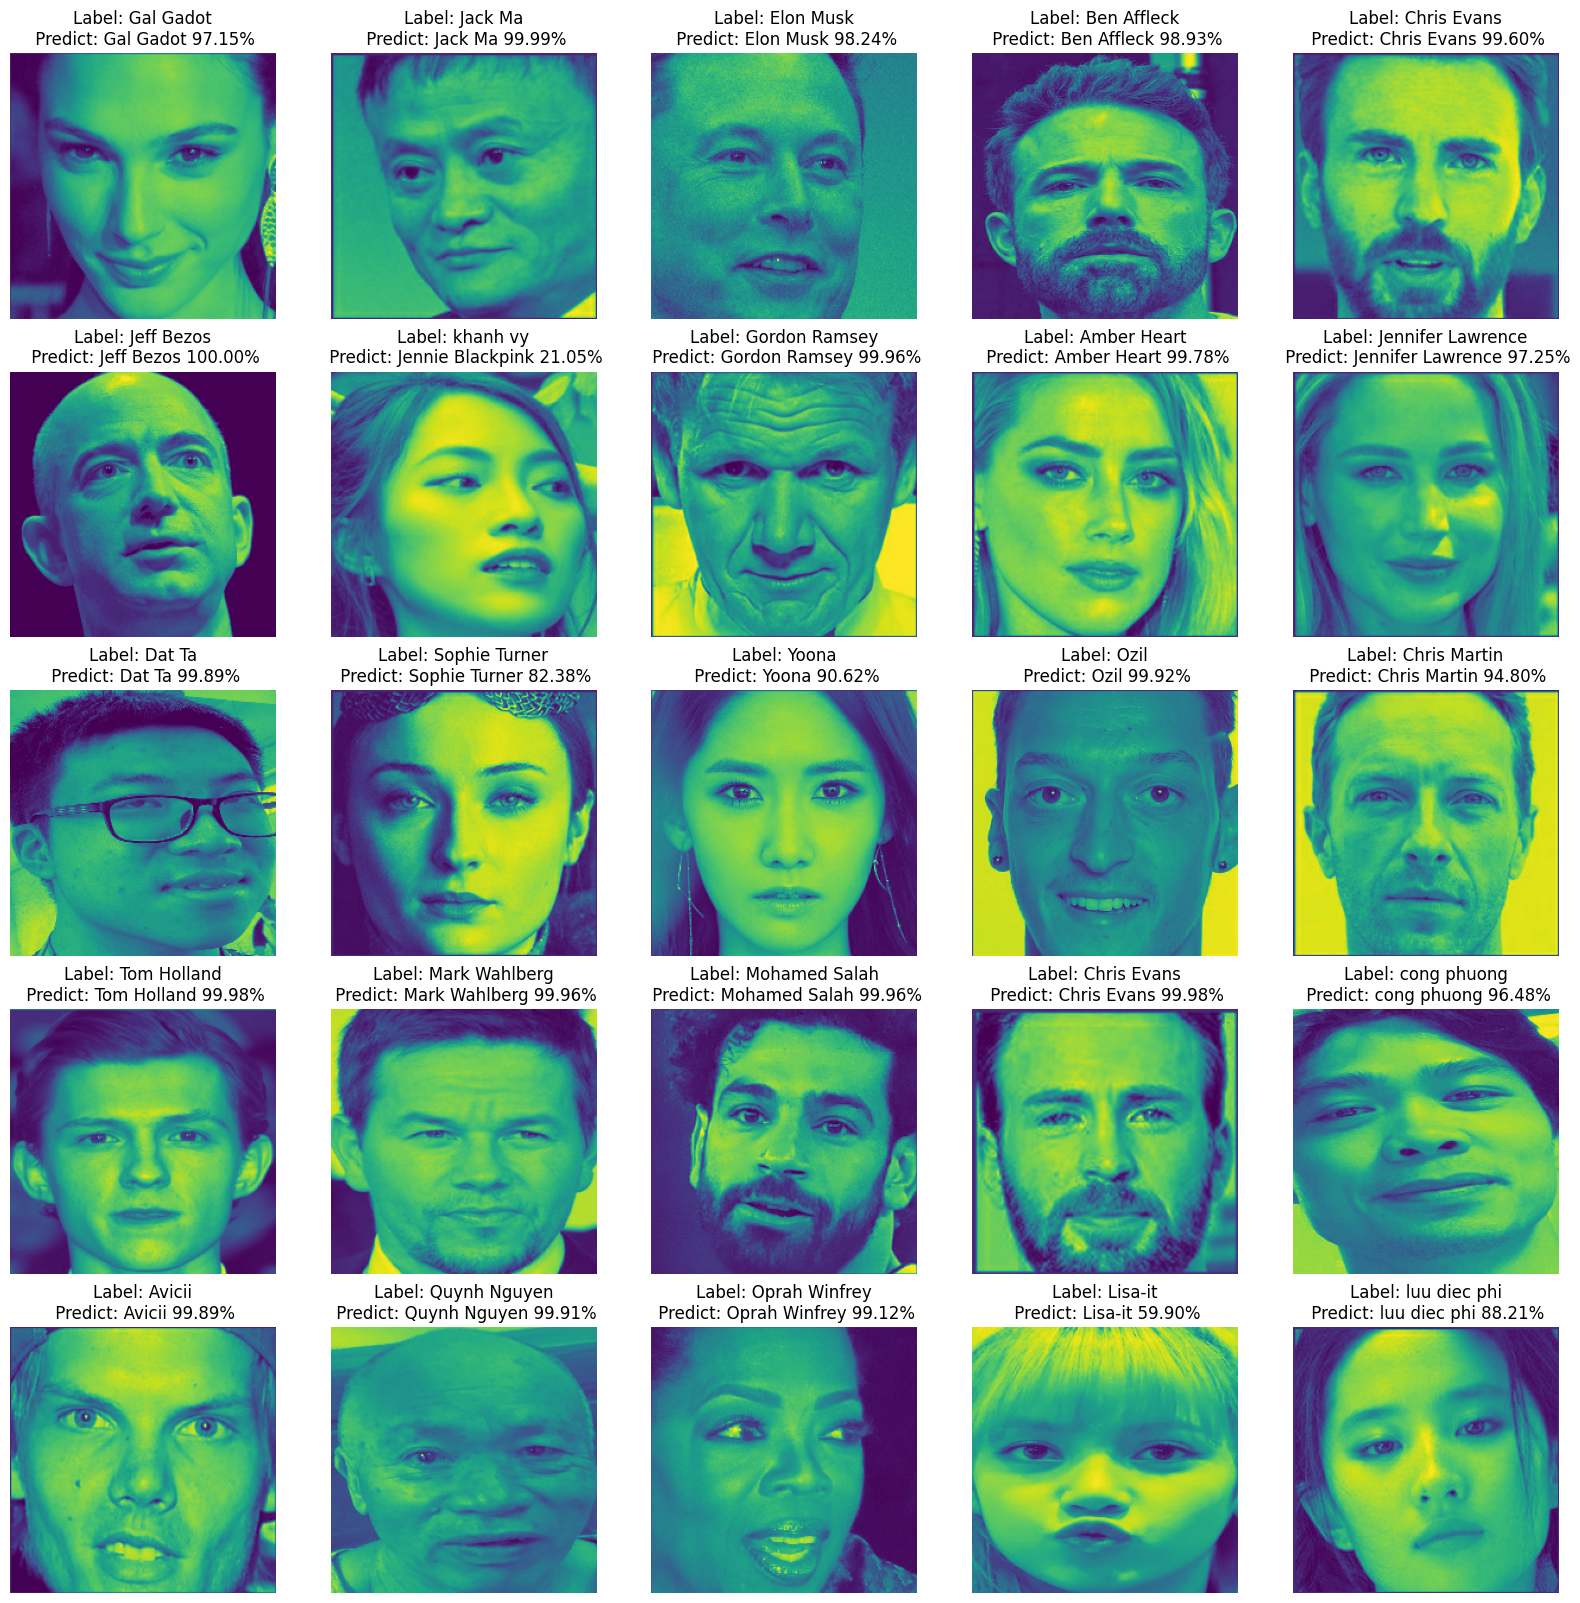

In [ ]:
plt.figure(figsize=(20, 20))

test_batch = val_ds.take(1)
prediction = trained_model.predict(test_batch)
for images, labels in test_batch:
    for i in range(25):
        img = images[i].numpy().astype("uint8")
        label = CLASS_NAMES[labels[i]]
        predict_label = CLASS_NAMES[np.argmax(prediction[i])]
        confidence = prediction[i][np.argmax(prediction[i])]

        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}\n Predict: {predict_label} {confidence :.2%}",fontsize = 12)
        plt.axis("off")

plt.savefig("/content/drive/MyDrive/Model/result.png")

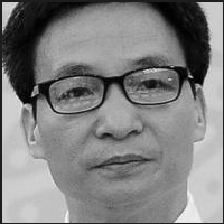

In [ ]:
test_img = keras.utils.load_img(
    "/content/drive/MyDrive/Dataset/Newest_data_test/vu duc dam/vu duc dam10.jpg",
    # "/content/drive/MyDrive/Model/410076200_1036268900763444_7352011443897460876_n.jpg",
    target_size=(224,224,3),
    color_mode="grayscale"
)
test_img

In [ ]:
pre = trained_model.predict(np.asarray(test_img)[None,:,:])
print(CLASS_NAMES[np.argmax(pre)], pre[0][np.argmax(pre)])

1/1 [==============================] - 1s 1s/step
vu duc dam 0.99212474


In [ ]:
# All test list
with open("/content/drive/MyDrive/Model/res.txt", "w") as file:
    for dir in test_dir.iterdir():
        print(dir)
        file.write(dir.name + "\n")
        for img_path in dir.iterdir():
            test_img = keras.utils.load_img(
                img_path,
                target_size=(224,224,3),
                color_mode="grayscale")
            test_prediction = trained_model.predict(np.asarray(test_img)[None,:,:])
            test_label = CLASS_NAMES[np.argmax(test_prediction)]
            test_confidence = test_prediction[0][np.argmax(test_prediction)]
            line = f"{img_path.name} Pre: {test_label} {test_confidence :.2%}"
            print(line)
            file.write("   "+ line + "\n")


/content/drive/MyDrive/Dataset/Newest_data_test/vu duc dam
1/1 [==============================] - 0s 29ms/step
vu duc dam14.jpg Pre: vu duc dam 99.18%
1/1 [==============================] - 0s 26ms/step
vu duc dam10.jpg Pre: vu duc dam 99.21%
1/1 [==============================] - 0s 24ms/step
vu duc dam21.jpg Pre: vu duc dam 99.24%
1/1 [==============================] - 0s 29ms/step
47.jpeg Pre: vu duc dam 91.60%
1/1 [==============================] - 0s 29ms/step
36.webp Pre: vu duc dam 98.00%
1/1 [==============================] - 0s 27ms/step
vu duc dam4.jpg Pre: vu duc dam 99.54%
1/1 [==============================] - 0s 30ms/step
vu duc dam8.jpg Pre: vu duc dam 56.08%
/content/drive/MyDrive/Dataset/Newest_data_test/Taylor Swift
1/1 [==============================] - 0s 27ms/step
Taylor Swift11.jpg Pre: Taylor Swift 81.59%
1/1 [==============================] - 0s 22ms/step
Taylor Swift21.jpg Pre: Taylor Swift 37.93%
1/1 [==============================] - 0s 19ms/step
Taylor Swift